In [16]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import pickle

import theano.tensor as tt

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19
    
def delay_cases(new_I_t, len_new_I_t, len_new_cases_obs , delay, delay_arr):
    """
    Delays the input new_I_t by delay and return and array with length len_new_cases_obs
    The initial delay of the output is set by delay_arr. 
    
    Take care that delay is smaller or equal than delay_arr, otherwise zeros are 
    returned, which could potentially lead to errors

    Also assure that len_new_I_t is larger then len(new_cases_obs)-delay, otherwise it 
    means that the simulated data is not long enough to be fitted to the data.
    """
    delay_mat = make_delay_matrix(n_rows=len_new_I_t, 
                                  n_columns=len_new_cases_obs, initial_delay=delay_arr)
    inferred_cases = interpolate(new_I_t, delay, delay_mat)
    return inferred_cases 

def make_delay_matrix(n_rows, n_columns, initial_delay=0):
    """
    Has in each entry the delay between the input with size n_rows and the output
    with size n_columns
    """
    size = max(n_rows, n_columns)
    mat = np.zeros((size, size))
    for i in range(size):
        diagonal = np.ones(size-i)*(initial_delay + i)
        mat += np.diag(diagonal, i)
    for i in range(1, size):
        diagonal = np.ones(size-i)*(initial_delay - i)
        mat += np.diag(diagonal, -i)
    return mat[:n_rows, :n_columns]

def interpolate(array, delay, delay_matrix):
    interp_matrix = tt.maximum(1-tt.abs_(delay_matrix - delay), 0)
    interpolation = tt.dot(array,interp_matrix)
    return interpolation

def print_median_CI(arr, prec=2):
    prec = 2
    f_trunc = lambda n: truncate_number(n, prec)
    med = f_trunc(np.median(arr))
    perc1, perc2 = (
        f_trunc(np.percentile(arr, q=2.5)),
        f_trunc(np.percentile(arr, q=97.5)),
    )
    return "{}\n [{}, {}]".format(med, perc1, perc2)
def truncate_number(number, precision):
    return "{{:.{}f}}".format(precision).format(number)

letter_size = 15
ci_location = [0.95,0.9]
alpha_texbox = 0.3
font_text = 10

In [3]:
# Data
confirmed_cases = cov19.get_jhu_confirmed_cases()

date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,3,15)
num_days_to_predict = 28

diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

#cases_obs = np.concatenate([np.nan*np.ones(diff_data_sim), cases_obs])
print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = (date_data_end - date_begin_sim).days
date_today = date_data_end + datetime.timedelta(days=1)

Cases yesterday (2020-03-15): 5795 and day before yesterday: 4585


In [4]:
#Models
np.random.seed(0)

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

def SI_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

In [7]:
# Runs SIR
with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.HalfCauchy('I_begin', beta=100)

    # fraction of people that are newly infected each day
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=10)

    N_germany = 83e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_germany)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                     len_new_cases_obs=len(new_cases_obs), 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred,
        sigma=(new_cases_inferred)**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)
    new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)
    
    # -------------------------------------------------------------------------- #
    # prediction, start with no changes in policy
    # -------------------------------------------------------------------------- #

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_no_change = SIR_model(λ=λ*tt.ones(num_days_to_predict), μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, N=N_germany)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_no_change]), 
                                     len_new_I_t=diff_data_sim + num_days_to_predict, 
                                     len_new_cases_obs=num_days_to_predict, 
                                     delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_no_change', new_cases_inferred)
    
    trace = pm.sample(draws=3000, tune=800, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [σ_obs, delay, μ, λ, I_begin]
Sampling 2 chains, 15 divergences: 100%|██████████| 7600/7600 [01:26<00:00, 87.98draws/s] 
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.95, 0.9, '$I_0 \\simeq $19.19\n [3.57, 79.38]')

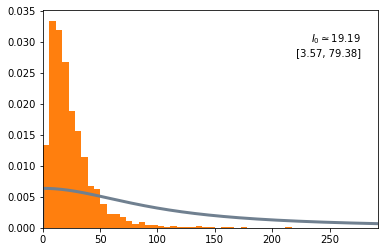

In [17]:
plt.figure()
ax = plt.gca()
ax.hist(trace.I_begin, bins=50, color='tab:orange', density=True, label='Posterior')
# ax.set_ylabel('Density')
# ax.set_xlabel('Number of infections at begin $I_0$')
limits = ax.get_xlim()
x = np.linspace(*limits, num=5000)
ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
        color="#708090", linewidth=3)
ax.set_xlim(*limits)
ax.set_xlim(0)
text = r"$I_0 \simeq $" + print_median_CI(trace.I_begin, prec=0)
ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
#ax.legend(loc='lower right')